# Getting bitcoin price data from investing.com data sheet


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.autograd import Variable

In [2]:
df = pd.read_csv(r'../Datasets/BitcoinData.csv', index_col='Date', parse_dates=True)   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
print(df)

               Price      Open      High       Low    Vol. Change %
Date                                                               
2022-02-15  43,605.3  42,550.3  43,658.8  42,460.1  56.13K    2.48%
2022-02-14  42,550.3  42,061.1  42,799.7  41,591.3  53.60K    1.16%
2022-02-13  42,061.1  42,205.5  42,725.1  41,880.1  25.88K   -0.34%
2022-02-12  42,205.2  42,388.4  43,006.4  41,776.8  37.88K   -0.43%
2022-02-11  42,388.4  43,519.3  43,915.1  42,023.4  69.95K   -2.60%
...              ...       ...       ...       ...     ...      ...
2015-11-19     325.0     335.9     335.6     323.4  86.38K   -3.26%
2015-11-18     335.9     333.9     337.4     329.4  78.36K    0.60%
2015-11-17     333.9     330.2     342.9     328.1  98.25K    1.12%
2015-11-16     330.2     317.5     332.0     314.1  87.14K    4.02%
2015-11-15     317.5     331.8     334.8     314.2  88.32K   -4.32%

[2285 rows x 6 columns]


In [3]:
df.dtypes

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [4]:
cleanData = df

repl_dict = {'[kK]': '*1e3', '[mM]': '*1e6', '[bB]': '*1e9', }
cleanData['Vol.'] = cleanData['Vol.'].replace(repl_dict, regex=True).map(pd.eval).astype(float)

cleanData['Price'] = cleanData['Price'].astype(str).str.replace(',', '').astype(float)
cleanData['Open'] = cleanData['Open'].astype(str).str.replace(',', '').astype(float)
cleanData['High'] = cleanData['High'].astype(str).str.replace(',', '').astype(float)
cleanData['Low'] = cleanData['Low'].astype(str).str.replace(',', '').astype(float)
cleanData['Change %'] = cleanData['Change %'].astype(str).str.replace('%', '').astype(float)


In [5]:
cleanData.describe()

,Price,Open,High,Low,Vol.,Change %
count,2285.000000,2285.000000,2285.000000,2285.000000,2.285000e+03,2285.000000
mean,13303.703720,13284.855011,13662.048709,12862.238293,4.889052e+05,0.293527
std,16723.975876,16714.244909,17178.001115,16180.627018,1.275485e+06,3.973664
min,317.500000,317.500000,323.300000,309.500000,2.600000e+02,-39.180000
25%,2362.400000,2344.000000,2494.000000,2263.300000,6.692000e+04,-1.290000
50%,7366.700000,7363.800000,7535.600000,7185.700000,1.326000e+05,0.220000
75%,11506.900000,11503.200000,11823.300000,11226.100000,4.881600e+05,1.910000
max,67527.900000,67528.700000,68990.600000,66334.900000,2.026000e+07,25.560000


In [6]:
cleanData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2285 entries, 2022-02-15 to 2015-11-15
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     2285 non-null   float64
 1   Open      2285 non-null   float64
 2   High      2285 non-null   float64
 3   Low       2285 non-null   float64
 4   Vol.      2285 non-null   float64
 5   Change %  2285 non-null   float64
dtypes: float64(6)
memory usage: 125.0 KB


In [7]:
cleanData.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-02-15,43605.3,42550.3,43658.8,42460.1,56130.0,2.48
2022-02-14,42550.3,42061.1,42799.7,41591.3,53600.0,1.16
2022-02-13,42061.1,42205.5,42725.1,41880.1,25880.0,-0.34
2022-02-12,42205.2,42388.4,43006.4,41776.8,37880.0,-0.43
2022-02-11,42388.4,43519.3,43915.1,42023.4,69950.0,-2.60


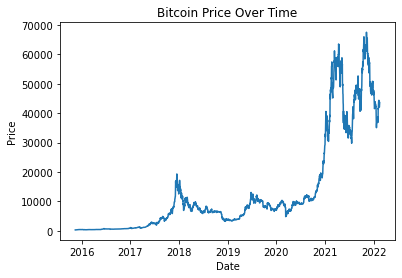

In [33]:
plt.plot(cleanData.Price)
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Adding neural net example using LSTM regression and 

In [9]:
# Our predictors will consist of everything but the price
# The target y, will be the values of price, the predictors will be the dataframe without the Price column
X, y = cleanData.drop(columns=['Price']), cleanData.Price.values
X.shape, y.shape

((2285, 5), (2285,))

In [10]:
# Here we will perform unit variance scaling required for pytorch neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [11]:
# We want to get the first N amount of days and then the next H amount of days that follow
# This requires getting x amount of samples from X and looking at the next 50 indices of y, and patching
# these together. Because of this, we will throwout the first 50 values of y.
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
# In this case, I am taking 100 samples of X, and the following 50 indices of y
X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(2137, 100, 5) (2137, 50)


In [13]:
y_mm[0]

array([1.        , 0.93669581, 0.91007344, 0.90249128, 0.90901259,
       0.93141835, 0.93592956, 0.90161344, 0.90748009, 0.91537322,
       0.92136485, 0.89666183, 0.86475605, 0.8926193 , 0.93362783,
       0.90088736, 0.90752324, 0.89826574, 0.9208798 , 0.97695595,
       0.95165332, 0.91858998, 0.91072215, 0.90080702, 0.91287955,
       0.8485041 , 0.84901444, 0.82871698, 0.85046064, 0.80895516,
       0.81274624, 0.79745397, 0.79550784, 0.81841054, 0.76106972,
       0.72771178, 0.71242843, 0.70449514, 0.7116235 , 0.64730756,
       0.61328753, 0.60563246, 0.62274737, 0.63808428, 0.63039797,
       0.63237832, 0.66286914, 0.64326503, 0.60011248, 0.63313267])

In [14]:
y_trans[99:149].squeeze(1)

array([1.        , 0.93669581, 0.91007344, 0.90249128, 0.90901259,
       0.93141835, 0.93592956, 0.90161344, 0.90748009, 0.91537322,
       0.92136485, 0.89666183, 0.86475605, 0.8926193 , 0.93362783,
       0.90088736, 0.90752324, 0.89826574, 0.9208798 , 0.97695595,
       0.95165332, 0.91858998, 0.91072215, 0.90080702, 0.91287955,
       0.8485041 , 0.84901444, 0.82871698, 0.85046064, 0.80895516,
       0.81274624, 0.79745397, 0.79550784, 0.81841054, 0.76106972,
       0.72771178, 0.71242843, 0.70449514, 0.7116235 , 0.64730756,
       0.61328753, 0.60563246, 0.62274737, 0.63808428, 0.63039797,
       0.63237832, 0.66286914, 0.64326503, 0.60011248, 0.63313267])

In [15]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [16]:
# We want to predict data several months or so in the future, here we will set the training data size at 85%
# and the remaining 15% can be used for testing data
total_samples = len(X)
train_test_cutoff = round(0.85 * total_samples) # TRAIN/TEST split cutoff

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:]

In [17]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (1987, 100, 5) (1987, 50)
Testing Shape: (150, 100, 5) (150, 50)


In [18]:
# Now we need to convert our test and training sets into tensors, which are like numpy arrays but are used
# in pytorch
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [19]:
# Here we will use the LSTM NN for our prediction algorithm. The input shape of the data depends on whether
# batch_first is true or not. Here, we will set it to be true, meaning the size of the input is (N, L, Hin),
# where N is the batch size, L is the sequence length, and Hin is the input size (number of features). In other
# words, we want the dimensions to be the rows of the dataframe in the first dimension, followed by the length of
# the dataframe in the second dimension, and finally the features (in which we have 5) in the final dimension.
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2]))

In [20]:
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([1987, 100, 5]) torch.Size([1987, 50])
Testing Shape: torch.Size([150, 100, 5]) torch.Size([150, 50])


In [21]:
# Lastly, we want to check the data logic of the test set. We want to predict 50 timesteps into the future with 
# Bitcoin. Based on split_sequence() above, we simply need to add the last sample of 100 days to X_test, run the 
# model on it, and compare these predictions with the last 50 days of y_test, these correspond to a period of 100
# days in X_test's last sample, proceeded immediately by the next 50 days in the last sample of y_test
# HERE, we want to check that the last 50 samples that we will be predicting match the last 50 values of y 
# in the test set
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[ 4.203e+02,  4.224e+02,  4.181e+02,  3.639e+04,  2.800e-01],
       [ 4.180e+02,  4.216e+02,  4.167e+02,  2.330e+04,  5.300e-01],
       [ 4.177e+02,  4.189e+02,  4.124e+02,  2.943e+04,  9.000e-02],
       [ 4.201e+02,  4.235e+02,  4.155e+02,  4.695e+04, -5.800e-01]])

In [22]:
X.iloc[-149:-145]

,Open,High,Low,Vol.,Change %
Date,,,,,
2016-04-11,420.3,422.4,418.1,36390.0,0.28
2016-04-10,418.0,421.6,416.7,23300.0,0.53
2016-04-09,417.7,418.9,412.4,29430.0,0.09
2016-04-08,420.1,423.5,415.5,46950.0,-0.58


In [23]:
y_check[-1]

array([430.7, 433.7, 434. , 430. , 427.1, 431.9, 421.8, 422.4, 415.4,
       454. , 453. , 442.4, 437. , 437.6, 441.8, 461.2, 463.2, 455.5,
       454. , 462.6, 442. , 434.7, 432.3, 449.8, 415.5, 416. , 410.7,
       394.3, 393.4, 386.7, 361.7, 360.3, 360. , 361.8, 378. , 370.8,
       355.8, 359.5, 353.7, 327.5, 318.4, 322.1, 322.8, 324.7, 321.1,
       325. , 335.9, 333.9, 330.2, 317.5])

In [24]:
cleanData.Price.values[-50:]

array([430.7, 433.7, 434. , 430. , 427.1, 431.9, 421.8, 422.4, 415.4,
       454. , 453. , 442.4, 437. , 437.6, 441.8, 461.2, 463.2, 455.5,
       454. , 462.6, 442. , 434.7, 432.3, 449.8, 415.5, 416. , 410.7,
       394.3, 393.4, 386.7, 361.7, 360.3, 360. , 361.8, 378. , 370.8,
       355.8, 359.5, 353.7, 327.5, 318.4, 322.1, 322.8, 324.7, 321.1,
       325. , 335.9, 333.9, 330.2, 317.5])

In [25]:
# Now to set up the LSTM NN class
class LSTM(torch.nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 = torch.nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = torch.nn.Linear(128, num_classes) # fully connected last layer
        self.relu = torch.nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out
    
# Most initializations of pytorch models are separated by 2 distince chunks
#     1. Any variables that the class will need to reference, for things such as hidden layer size, input size, 
#     and number of layers.
#     2. Defining the layers of the model (without connecting them) using the variables instantiated above.

In [26]:
# Training Function
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [27]:
# Time to instantiate an instance of our LSTM model
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [28]:
# Here we will use MSE (Mean Squared Error) as our loss function, this can be changed to an absolute error to be
# in accordance with Tashman method
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [29]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.09590, test loss: 0.02177
Epoch: 100, train loss: 0.00483, test loss: 0.00410
Epoch: 200, train loss: 0.00417, test loss: 0.00268
Epoch: 300, train loss: 0.00364, test loss: 0.00124
Epoch: 400, train loss: 0.00339, test loss: 0.00066
Epoch: 500, train loss: 0.00327, test loss: 0.00046
Epoch: 600, train loss: 0.00306, test loss: 0.00012
Epoch: 700, train loss: 0.00301, test loss: 0.00011
Epoch: 800, train loss: 0.00297, test loss: 0.00009
Epoch: 900, train loss: 0.00294, test loss: 0.00009


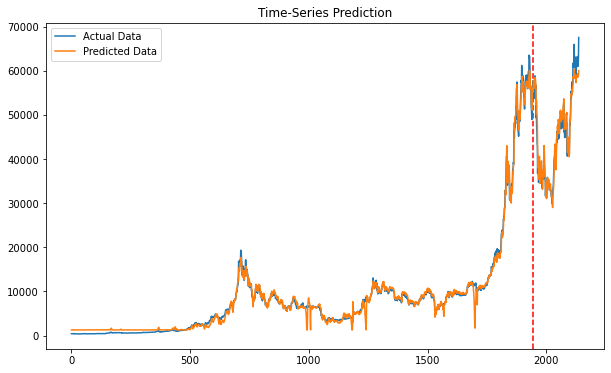

In [35]:
# Predictions
df_X_ss = ss.transform(cleanData.drop(columns=['Price'])) # old transformers
df_y_mm = mm.transform(cleanData.Price.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true[::-1], label='Actual Data') # actual plot
plt.plot(preds[::-1], label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [36]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

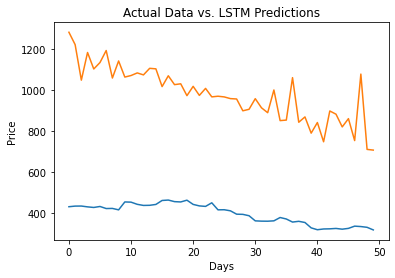

In [39]:
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.title('Actual Data vs. LSTM Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show();